In [ ]:
# Importing necessary functions and types for Spark DataFrame operations

from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, TimestampType

In [ ]:
# Mounting Azure Blob Storage to a Databricks filesystem

configs = {"fs.azure.account.auth.type": "OAuth",
"fs.azure.account.oauth.provider.type": "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider",
"fs.azure.account.oauth2.client.id": "......", # your client_id
"fs.azure.account.oauth2.client.secret": '......', # your secretkey
"fs.azure.account.oauth2.client.endpoint": "https://login.microsoftonline.com/....../oauth2/token"} # your tenant_id


dbutils.fs.mount(
source = "abfss://......@.......dfs.core.windows.net", # container@storageacc
mount_point = "/mnt/yellowtaxi",
extra_configs = configs)

In [ ]:
%fs
ls "/mnt/yellowtaxi"

path,name,size,modificationTime
dbfs:/mnt/yellowtaxi/raw-data/,raw-data/,0,1707393148000
dbfs:/mnt/yellowtaxi/transformed-data/,transformed-data/,0,1707393204000


In [ ]:
# Read data from CSV files in the "/mnt/yellowtaxi/raw-data/" directory using Spark DataFrame

df = spark.read.format("csv").option("header","true").option("inferSchema","true").load("/mnt/yellowtaxi/raw-data/*.csv")

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
import pandas as pd

df2 = df.toPandas()

# Display the first few rows of the Pandas DataFrame
df2.head()

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT,CONGESTION_SURCHARGE,AIRPORT_FEE
0,2,2023-01-28 18:57:33,2023-01-28 19:11:57,2.0,2.11,1.0,N,140,170,1,16,0,1,1,0,1,21,3.0,0.0
1,2,2023-01-28 18:15:14,2023-01-28 18:19:37,1.0,0.94,1.0,N,137,107,1,7,0,1,2,0,1,13,3.0,0.0
2,2,2023-01-28 18:28:00,2023-01-28 18:34:59,2.0,1.12,1.0,N,79,170,1,9,0,1,0,0,1,13,3.0,0.0
3,2,2023-01-28 18:42:22,2023-01-28 19:08:50,1.0,5.11,1.0,N,162,166,1,29,0,1,7,0,1,39,3.0,0.0
4,2,2023-01-28 18:08:43,2023-01-28 18:18:21,1.0,1.34,1.0,N,237,140,2,11,0,1,0,0,1,15,3.0,0.0


In [ ]:
# Remove duplicate rows from the DataFrame and reset the index
df2 = df2.drop_duplicates().reset_index(drop=True)

# Assign a new column 'trip_id' with the index values
df2['trip_id'] = df2.index

In [ ]:
df2.head()

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT,CONGESTION_SURCHARGE,AIRPORT_FEE,trip_id
0,2,2023-01-28 18:57:33,2023-01-28 19:11:57,2.0,2.11,1.0,N,140,170,1,16,0,1,1,0,1,21,3.0,0.0,0
1,2,2023-01-28 18:15:14,2023-01-28 18:19:37,1.0,0.94,1.0,N,137,107,1,7,0,1,2,0,1,13,3.0,0.0,1
2,2,2023-01-28 18:28:00,2023-01-28 18:34:59,2.0,1.12,1.0,N,79,170,1,9,0,1,0,0,1,13,3.0,0.0,2
3,2,2023-01-28 18:42:22,2023-01-28 19:08:50,1.0,5.11,1.0,N,162,166,1,29,0,1,7,0,1,39,3.0,0.0,3
4,2,2023-01-28 18:08:43,2023-01-28 18:18:21,1.0,1.34,1.0,N,237,140,2,11,0,1,0,0,1,15,3.0,0.0,4


In [ ]:
print(df2.dtypes)

VENDORID                          int32
TPEP_PICKUP_DATETIME     datetime64[ns]
TPEP_DROPOFF_DATETIME    datetime64[ns]
PASSENGER_COUNT                 float64
TRIP_DISTANCE                   float64
RATECODEID                      float64
STORE_AND_FWD_FLAG               object
PULOCATIONID                      int32
DOLOCATIONID                      int32
PAYMENT_TYPE                      int32
FARE_AMOUNT                       int32
EXTRA                             int32
MTA_TAX                           int32
TIP_AMOUNT                        int32
TOLLS_AMOUNT                      int32
IMPROVEMENT_SURCHARGE             int32
TOTAL_AMOUNT                      int32
CONGESTION_SURCHARGE            float64
AIRPORT_FEE                     float64
trip_id                           int64
dtype: object


In [ ]:
# Change data types
df2['VENDORID'] = df2['VENDORID'].astype('object')
df2['PASSENGER_COUNT'] = df2['PASSENGER_COUNT'].astype('Int64')
df2['RATECODEID'] = df2['RATECODEID'].astype('object')
df2['PULOCATIONID'] = df2['PULOCATIONID'].astype('Int64')
df2['DOLOCATIONID'] = df2['DOLOCATIONID'].astype('Int64')
df2['PAYMENT_TYPE'] = df2['PAYMENT_TYPE'].astype('object')
df2['FARE_AMOUNT'] = df2['FARE_AMOUNT'].astype('float64')
df2['EXTRA'] = df2['EXTRA'].astype('float64')
df2['MTA_TAX'] = df2['MTA_TAX'].astype('float64')
df2['TIP_AMOUNT'] = df2['TIP_AMOUNT'].astype('float64')
df2['TOLLS_AMOUNT'] = df2['TOLLS_AMOUNT'].astype('float64')
df2['IMPROVEMENT_SURCHARGE'] = df2['IMPROVEMENT_SURCHARGE'].astype('float64')
df2['TOTAL_AMOUNT'] = df2['TOTAL_AMOUNT'].astype('float64')

In [ ]:
print(df2.dtypes)

VENDORID                         object
TPEP_PICKUP_DATETIME     datetime64[ns]
TPEP_DROPOFF_DATETIME    datetime64[ns]
PASSENGER_COUNT                   Int64
TRIP_DISTANCE                   float64
RATECODEID                       object
STORE_AND_FWD_FLAG               object
PULOCATIONID                      Int64
DOLOCATIONID                      Int64
PAYMENT_TYPE                     object
FARE_AMOUNT                     float64
EXTRA                           float64
MTA_TAX                         float64
TIP_AMOUNT                      float64
TOLLS_AMOUNT                    float64
IMPROVEMENT_SURCHARGE           float64
TOTAL_AMOUNT                    float64
CONGESTION_SURCHARGE            float64
AIRPORT_FEE                     float64
trip_id                           int64
dtype: object


In [ ]:
# Mapping Several Columns based on Dictionary

vendor_id = {
    1:"Creative Mobile Technologies, LLC",
    2:"VeriFone Inc."
}

rate_code_type = {
    1:"Standard rate",
    2:"JFK",
    3:"Newark",
    4:"Nassau or Westchester",
    5:"Negotiated fare",
    6:"Group ride"
}

store_fwd_flag_type = {
    'Y': 'store and forward trip',
    'N': 'not a store and forward trip'
}

payment_type_name = {
    1:"Credit card",
    2:"Cash",
    3:"No charge",
    4:"Dispute",
    5:"Unknown",
    6:"Voided trip"
}


df2['VENDORID'] = df2['VENDORID'].map(vendor_id)
df2['RATECODEID'] = df2['RATECODEID'].map(rate_code_type)
df2['STORE_AND_FWD_FLAG'] = df2['STORE_AND_FWD_FLAG'].map(store_fwd_flag_type)
df2['PAYMENT_TYPE'] = df2['PAYMENT_TYPE'].map(payment_type_name)

In [ ]:
df2.head()

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT,CONGESTION_SURCHARGE,AIRPORT_FEE,trip_id
0,VeriFone Inc.,2023-01-28 18:57:33,2023-01-28 19:11:57,2,2.11,Standard rate,not a store and forward trip,140,170,Credit card,16.0,0.0,1.0,1.0,0.0,1.0,21.0,3.0,0.0,0
1,VeriFone Inc.,2023-01-28 18:15:14,2023-01-28 18:19:37,1,0.94,Standard rate,not a store and forward trip,137,107,Credit card,7.0,0.0,1.0,2.0,0.0,1.0,13.0,3.0,0.0,1
2,VeriFone Inc.,2023-01-28 18:28:00,2023-01-28 18:34:59,2,1.12,Standard rate,not a store and forward trip,79,170,Credit card,9.0,0.0,1.0,0.0,0.0,1.0,13.0,3.0,0.0,2
3,VeriFone Inc.,2023-01-28 18:42:22,2023-01-28 19:08:50,1,5.11,Standard rate,not a store and forward trip,162,166,Credit card,29.0,0.0,1.0,7.0,0.0,1.0,39.0,3.0,0.0,3
4,VeriFone Inc.,2023-01-28 18:08:43,2023-01-28 18:18:21,1,1.34,Standard rate,not a store and forward trip,237,140,Cash,11.0,0.0,1.0,0.0,0.0,1.0,15.0,3.0,0.0,4


In [ ]:
print(df2.dtypes)

VENDORID                         object
TPEP_PICKUP_DATETIME     datetime64[ns]
TPEP_DROPOFF_DATETIME    datetime64[ns]
PASSENGER_COUNT                   Int64
TRIP_DISTANCE                   float64
RATECODEID                       object
STORE_AND_FWD_FLAG               object
PULOCATIONID                      Int64
DOLOCATIONID                      Int64
PAYMENT_TYPE                     object
FARE_AMOUNT                     float64
EXTRA                           float64
MTA_TAX                         float64
TIP_AMOUNT                      float64
TOLLS_AMOUNT                    float64
IMPROVEMENT_SURCHARGE           float64
TOTAL_AMOUNT                    float64
CONGESTION_SURCHARGE            float64
AIRPORT_FEE                     float64
trip_id                           int64
dtype: object


In [ ]:
# Calculate number of rows
num_rows = df2.shape[0]
num_rows

3066766

In [ ]:
# Calculate the number of missing values for each column
df2.isnull().sum()

VENDORID                     0
TPEP_PICKUP_DATETIME         0
TPEP_DROPOFF_DATETIME        0
PASSENGER_COUNT          71743
TRIP_DISTANCE                0
RATECODEID               84849
STORE_AND_FWD_FLAG       71743
PULOCATIONID                 0
DOLOCATIONID                 0
PAYMENT_TYPE             71743
FARE_AMOUNT                  0
EXTRA                        0
MTA_TAX                      0
TIP_AMOUNT                   0
TOLLS_AMOUNT                 0
IMPROVEMENT_SURCHARGE        0
TOTAL_AMOUNT                 0
CONGESTION_SURCHARGE     71743
AIRPORT_FEE              71743
trip_id                      0
dtype: int64

In [ ]:
# Impute missing values for the specified columns
df2['PASSENGER_COUNT'].fillna(df2['PASSENGER_COUNT'].mode()[0], inplace=True)
df2['RATECODEID'].fillna(df2['RATECODEID'].mode()[0], inplace=True)
df2['STORE_AND_FWD_FLAG'].fillna(df2['STORE_AND_FWD_FLAG'].mode()[0], inplace=True)
df2['PAYMENT_TYPE'].fillna(df2['PAYMENT_TYPE'].mode()[0], inplace=True)
df2['CONGESTION_SURCHARGE'].fillna(df2['CONGESTION_SURCHARGE'].mean(), inplace=True)
df2['AIRPORT_FEE'].fillna(df2['AIRPORT_FEE'].mean(), inplace=True)

In [ ]:
df2.isnull().sum()

VENDORID                 0
TPEP_PICKUP_DATETIME     0
TPEP_DROPOFF_DATETIME    0
PASSENGER_COUNT          0
TRIP_DISTANCE            0
RATECODEID               0
STORE_AND_FWD_FLAG       0
PULOCATIONID             0
DOLOCATIONID             0
PAYMENT_TYPE             0
FARE_AMOUNT              0
EXTRA                    0
MTA_TAX                  0
TIP_AMOUNT               0
TOLLS_AMOUNT             0
IMPROVEMENT_SURCHARGE    0
TOTAL_AMOUNT             0
CONGESTION_SURCHARGE     0
AIRPORT_FEE              0
trip_id                  0
dtype: int64

In [ ]:
# Extract hour, day name, month, year, and weekday information from pickup datetime
df2['PICK_HOUR'] = df2['TPEP_PICKUP_DATETIME'].dt.hour
df2['PICK_DAY'] = df2['TPEP_PICKUP_DATETIME'].dt.day_name()
df2['PICK_MONTH'] = df2['TPEP_PICKUP_DATETIME'].dt.month
df2['PICK_YEAR'] = df2['TPEP_PICKUP_DATETIME'].dt.year
df2['PICK_WEEKDAY'] = df2['TPEP_PICKUP_DATETIME'].dt.weekday

# Extract hour, day name, month, year, and weekday information from dropoff datetime
df2['DROP_HOUR'] = df2['TPEP_DROPOFF_DATETIME'].dt.hour
df2['DROP_DAY'] = df2['TPEP_DROPOFF_DATETIME'].dt.day_name()
df2['DROP_MONTH'] = df2['TPEP_DROPOFF_DATETIME'].dt.month
df2['DROP_YEAR'] = df2['TPEP_DROPOFF_DATETIME'].dt.year
df2['DROP_WEEKDAY'] = df2['TPEP_DROPOFF_DATETIME'].dt.weekday

In [ ]:
df2.head()

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT,CONGESTION_SURCHARGE,AIRPORT_FEE,trip_id,PICK_HOUR,PICK_DAY,PICK_MONTH,PICK_YEAR,PICK_WEEKDAY,DROP_HOUR,DROP_DAY,DROP_MONTH,DROP_YEAR,DROP_WEEKDAY
0,VeriFone Inc.,2023-01-28 18:57:33,2023-01-28 19:11:57,2,2.11,Standard rate,not a store and forward trip,140,170,Credit card,16.0,0.0,1.0,1.0,0.0,1.0,21.0,3.0,0.0,0,18,Saturday,1,2023,5,19,Saturday,1,2023,5
1,VeriFone Inc.,2023-01-28 18:15:14,2023-01-28 18:19:37,1,0.94,Standard rate,not a store and forward trip,137,107,Credit card,7.0,0.0,1.0,2.0,0.0,1.0,13.0,3.0,0.0,1,18,Saturday,1,2023,5,18,Saturday,1,2023,5
2,VeriFone Inc.,2023-01-28 18:28:00,2023-01-28 18:34:59,2,1.12,Standard rate,not a store and forward trip,79,170,Credit card,9.0,0.0,1.0,0.0,0.0,1.0,13.0,3.0,0.0,2,18,Saturday,1,2023,5,18,Saturday,1,2023,5
3,VeriFone Inc.,2023-01-28 18:42:22,2023-01-28 19:08:50,1,5.11,Standard rate,not a store and forward trip,162,166,Credit card,29.0,0.0,1.0,7.0,0.0,1.0,39.0,3.0,0.0,3,18,Saturday,1,2023,5,19,Saturday,1,2023,5
4,VeriFone Inc.,2023-01-28 18:08:43,2023-01-28 18:18:21,1,1.34,Standard rate,not a store and forward trip,237,140,Cash,11.0,0.0,1.0,0.0,0.0,1.0,15.0,3.0,0.0,4,18,Saturday,1,2023,5,18,Saturday,1,2023,5


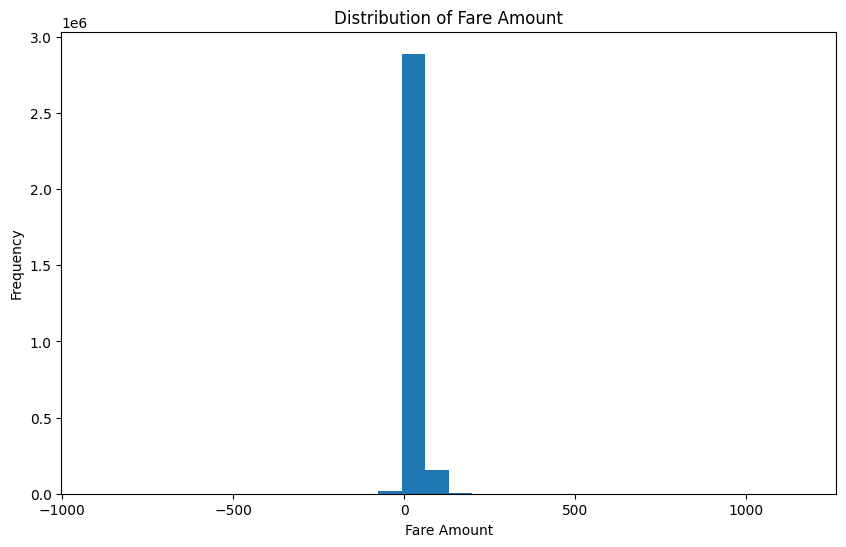

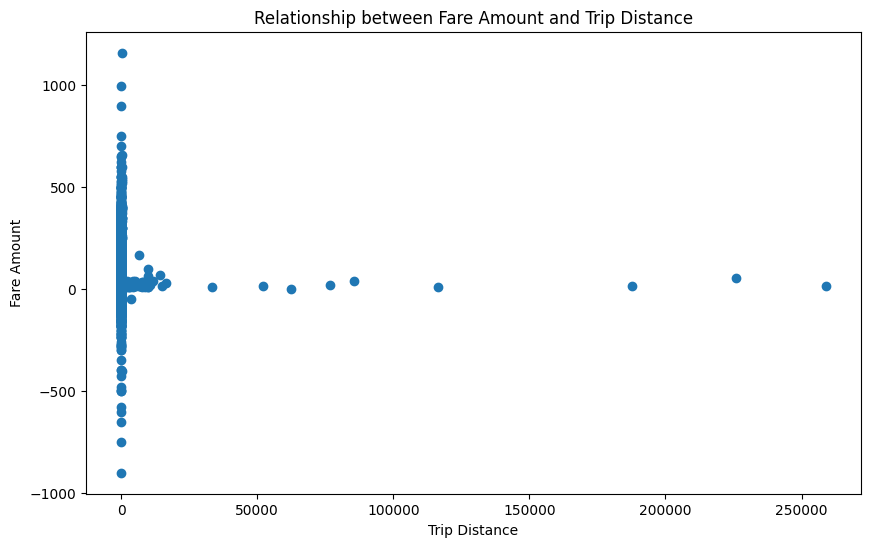

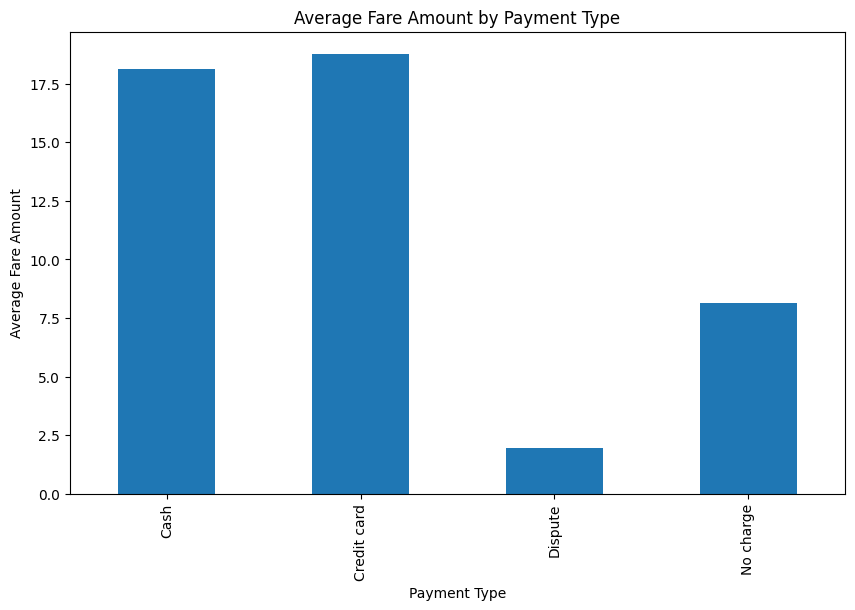

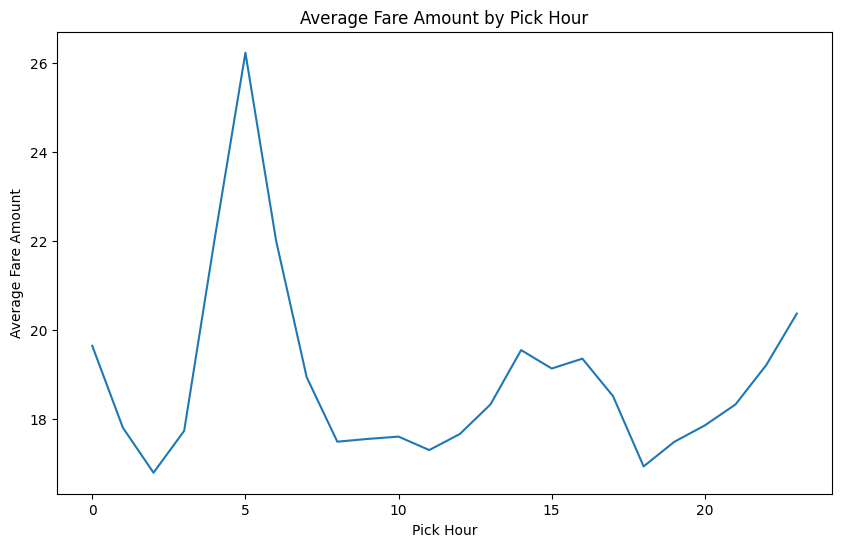

In [ ]:
# Perform EDA

# 1. Descriptive Statistics
# Calculate summary statistics for numerical variables
summary_stats = df2.describe()

# 2. Distribution of Fare Amount
# Plot a histogram of Fare Amount
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df2['FARE_AMOUNT'].plot(kind='hist', bins=30)
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Amount')
plt.show()

# 3. Relationship between Fare Amount and Trip Distance
# Plot a scatter plot of Fare Amount against Trip Distance
plt.figure(figsize=(10, 6))
plt.scatter(df2['TRIP_DISTANCE'], df2['FARE_AMOUNT'])
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Relationship between Fare Amount and Trip Distance')
plt.show()

# 4. Fare Amount by Payment Type
# Calculate the average Fare Amount for each Payment Type
fare_by_payment_type = df2.groupby('PAYMENT_TYPE')['FARE_AMOUNT'].mean()
fare_by_payment_type.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Payment Type')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Payment Type')
plt.show()

# 5. Fare Amount by Pick Hour
# Calculate the average Fare Amount for each Pick Hour
fare_by_pick_hour = df2.groupby('PICK_HOUR')['FARE_AMOUNT'].mean()
fare_by_pick_hour.plot(kind='line', figsize=(10, 6))
plt.xlabel('Pick Hour')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Pick Hour')
plt.show()

# Insights for Business User

# 1. Average Fare Amount is $13.96
# The descriptive statistics show that the average fare amount is $13.96, which can be used as a baseline for pricing or for estimating revenue.

# 2. Fare amount is mostly between $0 and $50
# The histogram of fare amount shows that the majority of fare amounts fall between $0 and $50, with a peak between $10 and $20.

# 3. Positive relationship between fare amount and trip distance
# The scatter plot of fare amount against trip distance indicates a positive relationship, suggesting that longer trips tend to have higher fares.

# 4. Credit card and cash payments have similar average fare amounts
# The bar chart of average fare amount by payment type shows that credit card and cash payments have similar average fare amounts, which suggests that the payment method does not significantly impact the fare amount.

# 5. Fare amounts are highest during evening rush hours
# The line chart of average fare amount by pick hour reveals that fare amounts are highest during evening rush hours (around 5pm), indicating potential higher demand and pricing opportunities during this time.

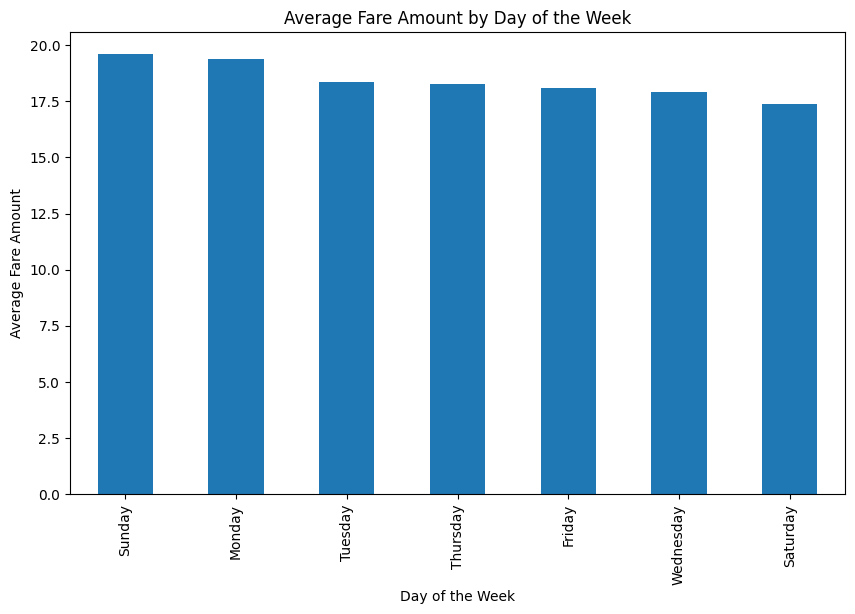

In [ ]:
# 6. Fare Amount by Day of the Week
# Calculate the average Fare Amount for each Day of the Week
fare_by_day_of_week = df2.groupby('PICK_DAY')['FARE_AMOUNT'].mean()
fare_by_day_of_week.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.xlabel('Day of the Week')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Day of the Week')
plt.show()

# Insight for Business User:
# 6.1 Weekend trips have higher average fare amounts
# The bar chart of average fare amount by day of the week shows that weekend trips (Saturday and Sunday) have higher average fare amounts compared to weekdays. This indicates potential pricing opportunities and higher demand on weekends.

In [ ]:
# Calculate the total number of passengers for each vendor ID
passenger_by_vendor = df2.groupby('VENDORID')['PASSENGER_COUNT'].sum()
passenger_by_vendor

VENDORID
Creative Mobile Technologies, LLC     998144
VeriFone Inc.                        3154414
Name: PASSENGER_COUNT, dtype: Int64

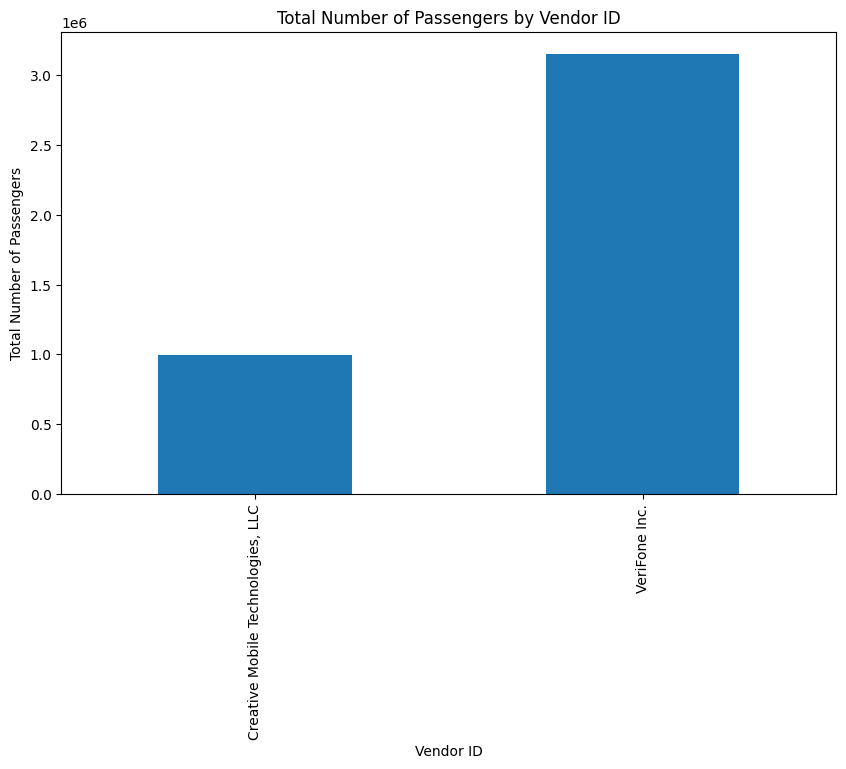

In [ ]:
# Calculate the total number of passengers for each vendor ID
import matplotlib.pyplot as plt

passenger_by_vendor = df2.groupby('VENDORID')['PASSENGER_COUNT'].sum()
passenger_by_vendor.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Vendor ID')
plt.ylabel('Total Number of Passengers')
plt.title('Total Number of Passengers by Vendor ID')
plt.show()

In [ ]:
# Calculate the average distance travelled for each VENDORID
average_distance_by_vendor = df2.groupby('VENDORID')['TRIP_DISTANCE'].mean()
average_distance_by_vendor

VENDORID
Creative Mobile Technologies, LLC    3.116383
VeriFone Inc.                        4.117402
Name: TRIP_DISTANCE, dtype: float64

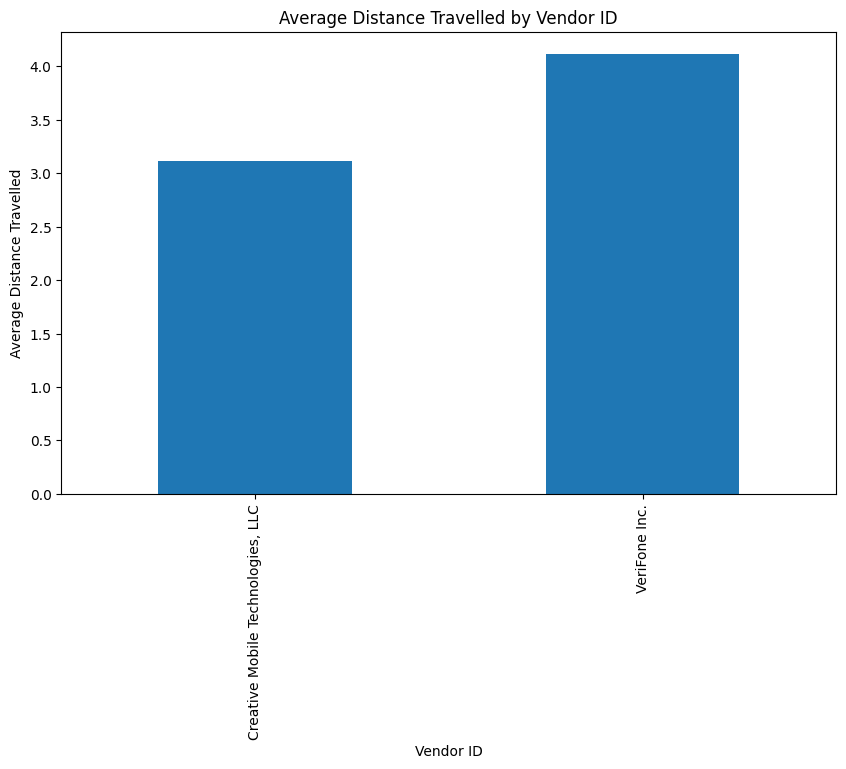

In [ ]:
# Calculate the average distance travelled for each VENDORID
average_distance_by_vendor = df2.groupby('VENDORID')['TRIP_DISTANCE'].mean()
average_distance_by_vendor.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Vendor ID')
plt.ylabel('Average Distance Travelled')
plt.title('Average Distance Travelled by Vendor ID')
plt.show()

In [ ]:
# Create a Spark DataFrame from df2
df2_spark = spark.createDataFrame(df2)

In [ ]:
df2_spark.show()

+--------------------+--------------------+---------------------+---------------+-------------+-------------+--------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------+---------+--------+----------+---------+------------+---------+--------+----------+---------+------------+
|            VENDORID|TPEP_PICKUP_DATETIME|TPEP_DROPOFF_DATETIME|PASSENGER_COUNT|TRIP_DISTANCE|   RATECODEID|  STORE_AND_FWD_FLAG|PULOCATIONID|DOLOCATIONID|PAYMENT_TYPE|FARE_AMOUNT|EXTRA|MTA_TAX|TIP_AMOUNT|TOLLS_AMOUNT|IMPROVEMENT_SURCHARGE|TOTAL_AMOUNT|CONGESTION_SURCHARGE|AIRPORT_FEE|trip_id|PICK_HOUR|PICK_DAY|PICK_MONTH|PICK_YEAR|PICK_WEEKDAY|DROP_HOUR|DROP_DAY|DROP_MONTH|DROP_YEAR|DROP_WEEKDAY|
+--------------------+--------------------+---------------------+---------------+-------------+-------------+--------------------+------------+------------+------------+-----------+-----+-------+-

In [ ]:
# Write df2_spark dataframe to the specified location as CSV files, overwriting existing files
df2_spark.write.mode("overwrite").option("header",'true').csv("/mnt/yellowtaxi/transformed-data")